In [17]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [18]:
from src.codes.basic import *
from src.codes.utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw_test import ecsw_red
from importlib import reload


### class for data (geometry, material property, mesh)

In [19]:
n_ref = np.array([40*5, 10*5], dtype=int)
w = np.array([ 0.4, 0.1])
L = np.sum(w)

# Create arrays of zeros and ones
zeros_array = np.zeros((1, n_ref[0]))
ones_array = np.ones((1, n_ref[1]))

# Concatenate along the second axis (axis=1)
mat_layout = np.concatenate((zeros_array, ones_array), axis=1)
src_layout = np.concatenate((zeros_array, ones_array), axis=1)

In [20]:
fdict = {}

tune = 1

cond_list = []
cond_list.append(lambda T,mu: 1.05*mu*tune + 2150/(T-73.15))
cond_list.append(lambda T,mu: mu*tune*7.51 + 2.09e-2*T - 1.45e-5*T**2 + 7.67e-9*T**3)
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append(lambda T,mu: -2150/(T-73.15)**2 )
dcond_list.append(lambda T,mu: 2.09e-2 - 2*1.45e-5*T + 3*7.67e-9*T**2)
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 35000.0 + 0.0*T)
qext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [21]:
# fdict = {}

# cond_list = []
# cond_list.append( lambda T,mu: np.exp(mu)*T + 100. + 0.*T )
# cond_list.append( lambda T,mu: 2.09e-2*T*mu + 100. + 0.*T )
# fdict["cond"] = cond_list

# dcond_list = []
# dcond_list.append( lambda T,mu: np.exp(mu) + 0. + 0.*T )
# dcond_list.append( lambda T,mu: 2.09e-2*mu + 0. + 0.*T )
# fdict["dcond"] = dcond_list


# qext_list = []
# qext_list.append( lambda T,mu: 100.0 + 0.0*T )
# qext_list.append( lambda T,mu: 0.0 + 0.*T)
# fdict["qext"] = qext_list

# dqext_list = []
# dqext_list.append( lambda T,mu: 0.0 + 0.*T)
# dqext_list.append( lambda T,mu: 0.0 + 0.*T)
# fdict["dqext"] = dqext_list

In [22]:
bc = {}
bc['x_min']={'type':'refl','value':np.nan}
bc['x_max']={'type':'dirichlet','value':273.15+300.}   

In [23]:
print(mat_layout.flatten().shape[0])

250


### Simulate FOS

In [24]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []
# 


 Snap 0



 Snap 1

 Snap 2

 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


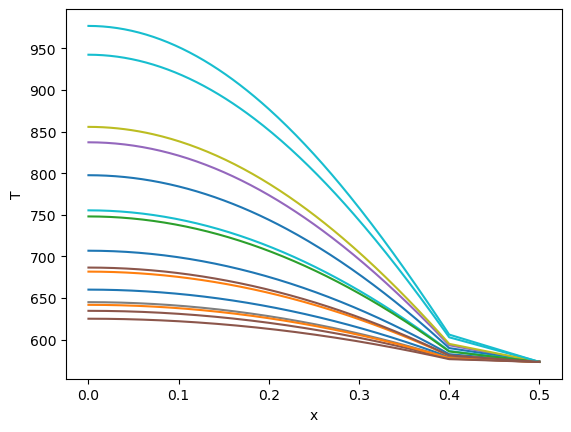

In [25]:
fig, ax = plt.subplots()

for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param, pb_dim=1)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 273.15
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init, tol=1e-5)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    plot1D(d.xi[0], NL_solution_p, ax=ax)

plt.show()


In [26]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 251)

### ECSW Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

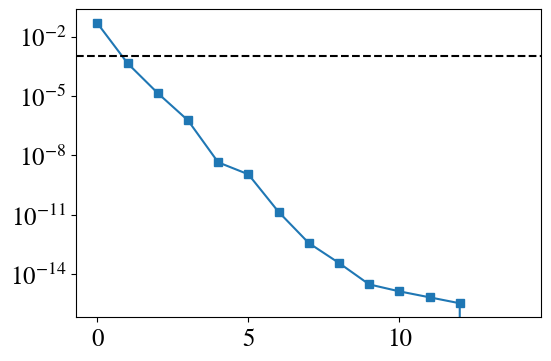

2


In [111]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-4)
n_sel+=1
V_sel = U[:, :n_sel]
print(n_sel)

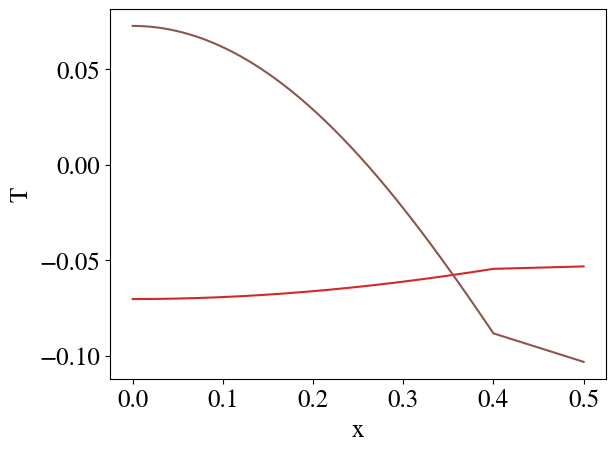

In [112]:
fig, ax = plt.subplots()

for i in range(n_sel):
    plot1D(d.xi[0],V_sel[:,i],ax=ax)

plt.show()


#### Step 2: ECSW

In [113]:
tic_h_setup_b = time.time()
tol = 1e-8
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

In [114]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 4.592467820937585e-05


In [115]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

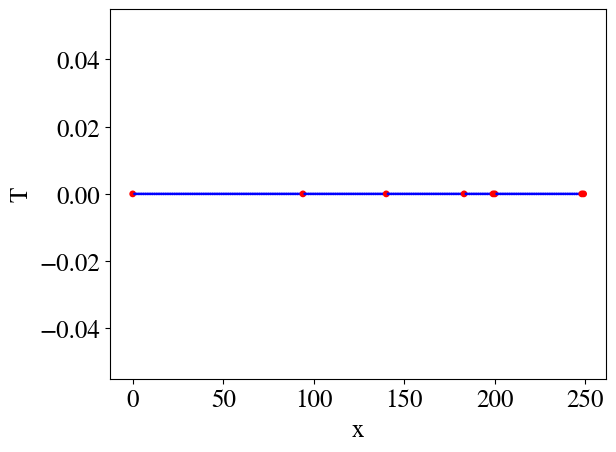

In [116]:
plot1D(np.arange(d.ncells[0]), np.zeros_like(xi), scattr=True, clr=colors, sz=sizes)

In [117]:
mask_xi = xi>0


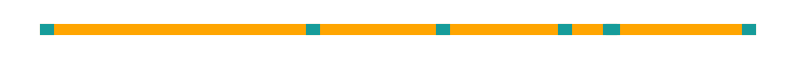

In [118]:
# Initialize the data for a 1D line plot of size 20
x_values = np.arange(0, len(xi), 1)
y_values = np.zeros_like(x_values)  # All y-values are 0 to represent a line on the x-axis

# Initialize the figure and axis for the line plot
fig, ax = plt.subplots(figsize=((10,0.5)))
lw = 4+2+2

ax.plot(x_values, y_values, color='orange',linewidth=lw)

# Draw the line plot
for i in range(len(x_values) - 1):
    if mask_xi[i]:  # Change the color of specific line elements at positions 5 and 10
        color = '#169C9A'

        ax.plot(x_values[i:i+2], y_values[i:i+2], color=color,linewidth=lw)


ax.set_yticklabels([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_xticks([])

for spine in ['top', 'right', 'left','bottom']:
    ax.spines[spine].set_visible(False)

plt.show()

In [119]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 3.2%



### ROM Simulation

In [120]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [121]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [122]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [123]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [124]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [125]:
# Time taken to simulate a ROM *with* hyper-reduction
tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

In [126]:
speed_up = []
fos_sim_time = toc_fos - tic_fos
err = []

for i in range(100):
    param_rom = random.choice(params_rm)  
    d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
    FOS_test_loop = FOS_FEM(d_test,quad_deg)
    # NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)

    tic_rom = time.time()
    ROM_h_i = rom_class.rom_ecsw(d_test, quad_deg)
    NL_solution_p_reduced_loop = ROM_h_i.solve_rom(T_init_rom,xi,V_sel)
    toc_rom = time.time()
    
    rom_sim_time = toc_rom - tic_rom
    speed_up.append(fos_sim_time/(rom_sim_time))

    # sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
    # err.append(np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1)))



RMS_error is 0.015187933185132455 %


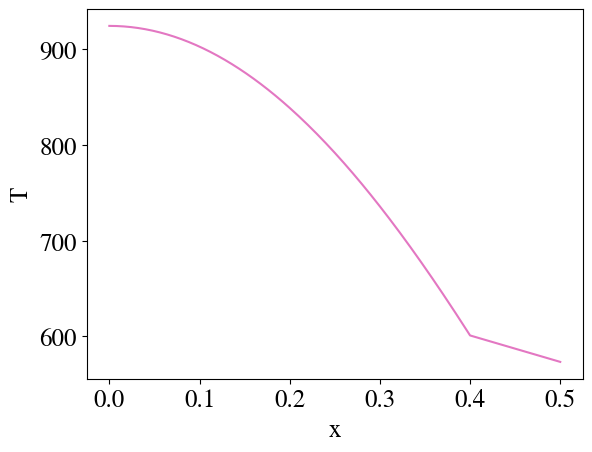

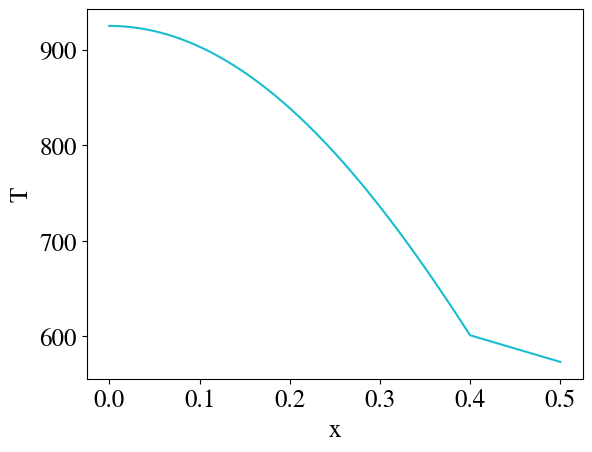

In [127]:
FOS_test_loop = FOS_FEM(d_test,quad_deg)
NL_solution_p_fos_test_loop, _, _, _, = solve_fos(FOS_test_loop,T_init_fos)

sol_red_loop = V_sel@NL_solution_p_reduced_loop.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot1D(d_test.xi[0], sol_red_loop)

print(f"RMS_error is {np.linalg.norm(sol_red_loop-NL_solution_p_fos_test_loop.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test_loop.reshape(-1,1))} %")
plot1D(d_test.xi[0], NL_solution_p_fos_test_loop)

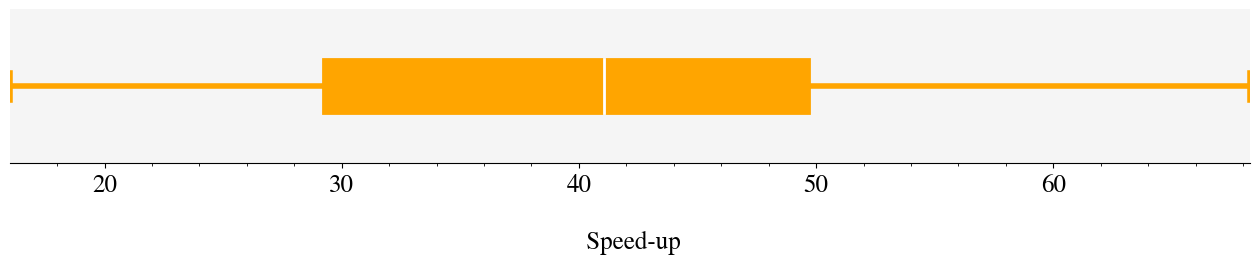

In [128]:
from matplotlib import rcParams

# rcParams['font.family'] = 'Latin Modern Roman 10'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 18

# Create Figure and Axes
fig, ax = plt.subplots(figsize=(8*2, 1*2))
ax.set_facecolor('#f5f5f5')  # Using the HEX code for gray

# Create Box Plot with patch_artist=True
box = ax.boxplot(speed_up, vert=False, patch_artist=True,widths=0.35,
                 boxprops=dict(linewidth=2.0, color='orange'),
                 whiskerprops=dict(linewidth=4.0, color='orange'),
                 capprops=dict(linewidth=4.0, color='orange'),
                 medianprops=dict(linewidth=2.0, color='white'),
                 flierprops=dict(marker='.', markerfacecolor='#ffb300', markeredgecolor='#ffb300', markersize=8, linestyle='none'))


ax.set_ylim(0.9, 1.1)

# Set Box Fill Color
for patch in box['boxes']:
    patch.set_facecolor('orange')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel('\n Speed-up')

plt.autoscale(enable=True, tight=True)
ax.minorticks_on()

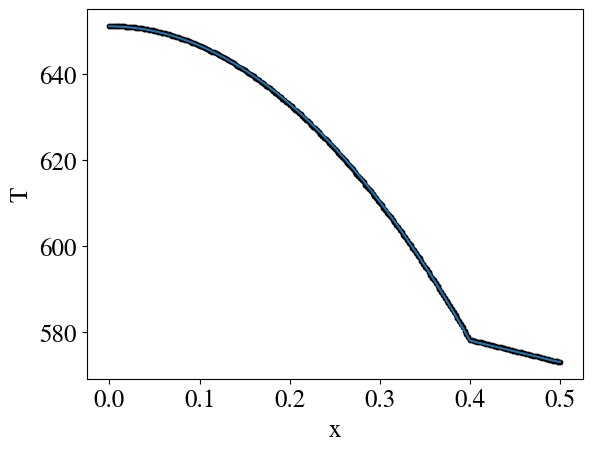

RMS_error is 0.02677213484452919 %


In [129]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)

fig, ax = plt.subplots()

plot1D(d_test.xi[0], sol_red, ax=ax)
plot1D(d_test.xi[0], NL_solution_p_fos_test, ax=ax, scattr=True, clr='k', sz=10)

plt.show()

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

In [130]:

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")



ROM Error without hyperreduction is 0.026771949629897134 %



#### Speedups

In [131]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [132]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:1.1574455009900837
speedup with hyperreduction:49.72465150665983
